# **Training CNN Model**


> ### **Présenté par : Rania Charef et Sarra Sabbagh**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 22.jpg to 22.jpg


In [ ]:
!unzip -uq "/content/ResizeDataset.zip" -d "/content"

unzip:  cannot find or open /content/ResizeDataset.zip, /content/ResizeDataset.zip.zip or /content/ResizeDataset.zip.ZIP.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [ ]:
train_dir='/content/drive/MyDrive/Dataset'

In [ ]:
Labels = ['Benign', 'Malignant']

In [ ]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant


In [ ]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [ ]:
module_selection = ("efficientnet_v2_imagenet1k_b0", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [ ]:
print(MODULE_HANDLE)
#https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2

https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2


In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [ ]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 6,576,210
Trainable params: 656,898
Non-trainable params: 5,919,312
_____

In [ ]:
LEARNING_RATE = 0.0005
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [ ]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size, callbacks=[callback])

Epoch 1/15
1/1 [==============================] - 31s 31s/step - loss: 0.7741 - accuracy: 0.2500 - val_loss: 0.6513 - val_accuracy: 0.5625
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 0.7318 - accuracy: 0.5000 - val_loss: 0.5816 - val_accuracy: 0.8750
Epoch 3/15
1/1 [==============================] - 1s 798ms/step - loss: 0.5340 - accuracy: 0.8125 - val_loss: 0.5717 - val_accuracy: 0.6875
Epoch 4/15
1/1 [==============================] - 0s 487ms/step - loss: 0.4359 - accuracy: 0.8750 - val_loss: 0.6009 - val_accuracy: 0.6250
Epoch 5/15
1/1 [==============================] - 1s 510ms/step - loss: 0.2919 - accuracy: 0.8750 - val_loss: 0.5089 - val_accuracy: 0.6250
Epoch 6/15
1/1 [==============================] - 0s 499ms/step - loss: 0.3370 - accuracy: 1.0000 - val_loss: 0.5060 - val_accuracy: 0.6875
Epoch 7/15
1/1 [==============================] - 1s 508ms/step - loss: 0.2084 - accuracy: 1.0000 - val_loss: 0.4919 - val_accuracy: 0.6875
Epoch 8/15
1/1 [========

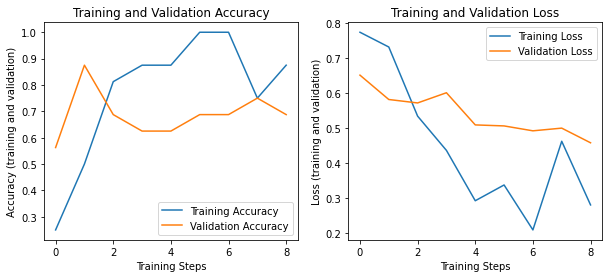

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 1s 1s/step
class: Benign, confidence: 0.745776


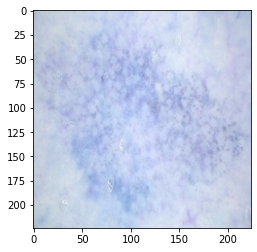

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: Benign, confidence: 0.764713


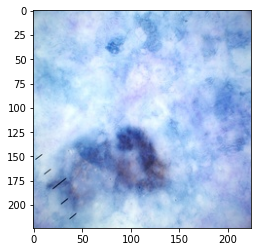

1/1 [==============================] - 0s 24ms/step
class: Benign, confidence: 0.577244


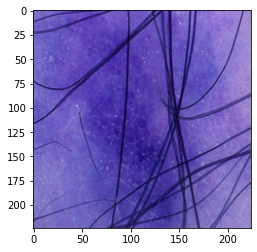

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 27ms/step
class: Malignant, confidence: 0.884346


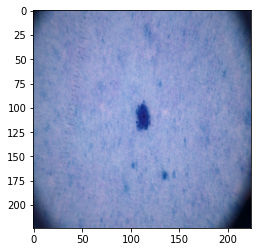

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 23ms/step
class: Benign, confidence: 0.857053


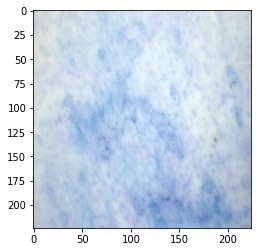

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 25ms/step
class: Malignant, confidence: 0.635980


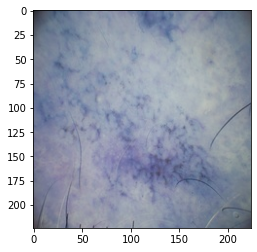

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: Benign, confidence: 0.650878


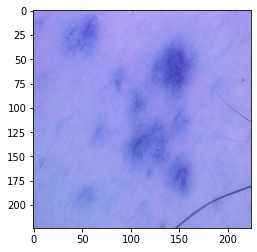

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 23ms/step
class: Benign, confidence: 0.805462


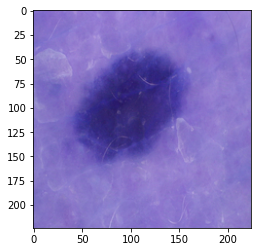

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: Benign, confidence: 0.946651


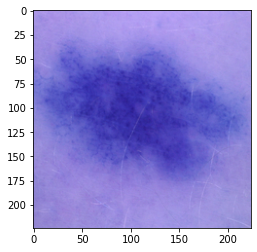

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 29ms/step
class: Benign, confidence: 0.720097


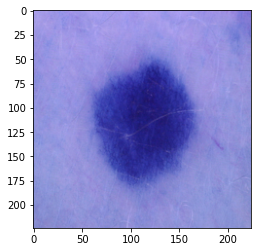

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: Benign, confidence: 0.880360


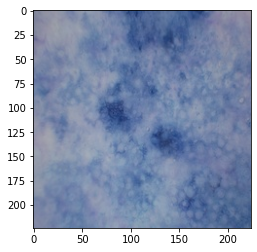

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 25ms/step
class: Benign, confidence: 0.709703


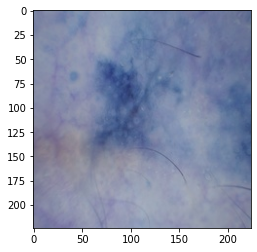

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 36ms/step
class: Benign, confidence: 0.825527


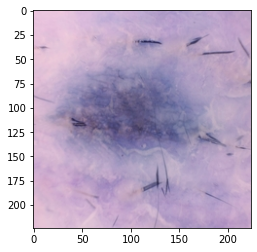

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 25ms/step
class: Benign, confidence: 0.818909


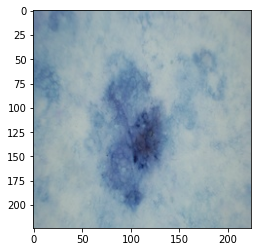

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 32ms/step
class: Benign, confidence: 0.935911


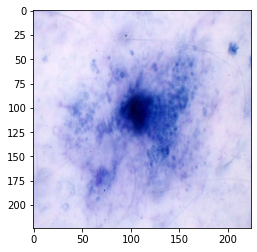

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 27ms/step
class: Malignant, confidence: 0.647969


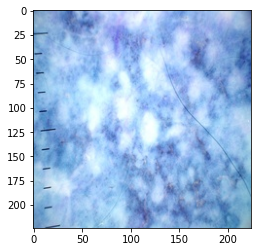

<Figure size 432x288 with 0 Axes>

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img, cmap='gray')
    plt.figure(idx)    
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

1/1 [==============================] - 1s 888ms/step
Classification Report
              precision    recall  f1-score   support

      benign       0.71      0.62      0.67         8
   malignant       0.67      0.75      0.71         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16

1/1 [==============================] - 0s 266ms/step - loss: 0.5899 - accuracy: 0.7500
[0.5898966193199158, 0.75]


Confusion Matrix


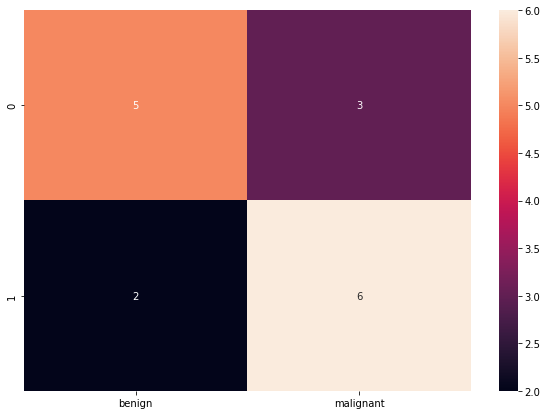

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [ ]:
cd /content/drive/MyDrive/Buffml/code

[Errno 2] No such file or directory: '/content/drive/MyDrive/Buffml/code'
/content


#Export as saved model and convert to TFLite

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

'/tmp/saved_models/1670883564'

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: malignant, file: malignant/11.jpg
1/1 [==============================] - 1s 623ms/step
PREDICTED: class: Benign, confidence: 0.880360


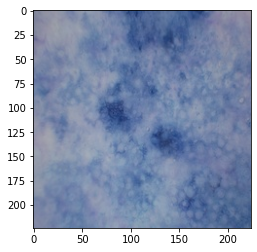

<Figure size 432x288 with 0 Axes>

SOURCE: class: malignant, file: malignant/16.jpg
1/1 [==============================] - 0s 23ms/step
PREDICTED: class: Benign, confidence: 0.764713


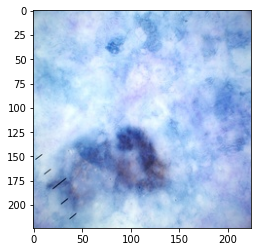

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

26126552

## Data Augmentation

### Importing packages Import

In [ ]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 36.4 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
import albumentations as A
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

### Load the files to variable 'images'

In [ ]:
images = []

In [ ]:

for filename in os.listdir('/content/drive/MyDrive/Dataset/malignant'):
  img = cv2.imread(os.path.join('/content/drive/MyDrive/Dataset/malignant', filename))
  if img is not None:
      images.append(img)

In [ ]:
len(images)

20

### Sample Image details

(224, 224, 3)
224
224
3


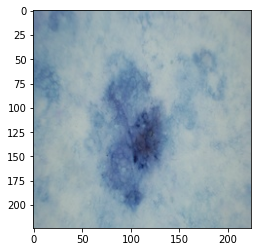

In [ ]:
#Print Shape of the sample image
print(images[0].shape)

#Get the width, height and channel values from sample image
w,h,c=images[0].shape

#Print width, height and channel values of sample image
print(w)
print(h)
print(c)

#Show the sample image
plt.imshow(images[0])
plt.show()



### Get the width, height and channel values for all images

In [ ]:
#Initialize the empty array for height=h, width=w and channel=c

h=[]

w=[]

c=[]

for i in range(len(images)):

  x,y,z=images[i].shape

  w.append(x)

  h.append(y)

  c.append(z)

### Show the first 10 sample images

Image: 1


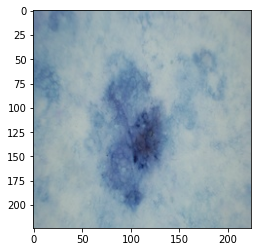

Image: 2


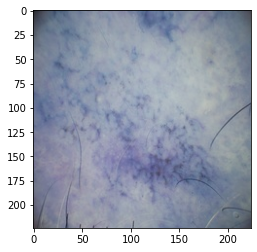

Image: 3


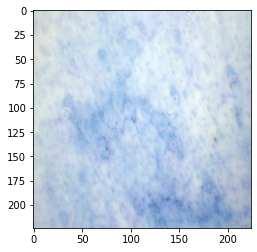

Image: 4


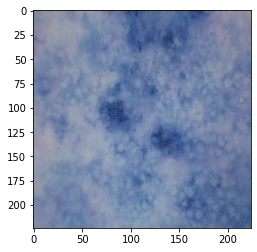

Image: 5


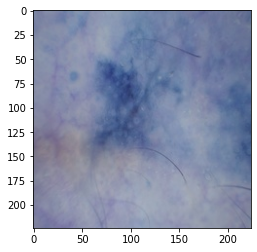

Image: 6


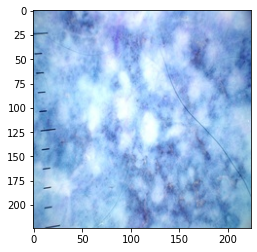

Image: 7


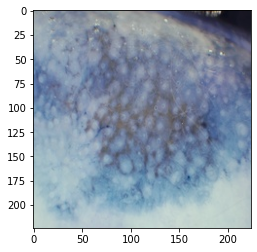

Image: 8


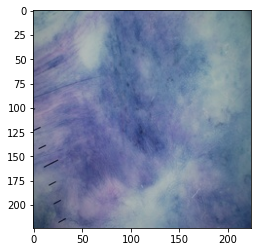

Image: 9


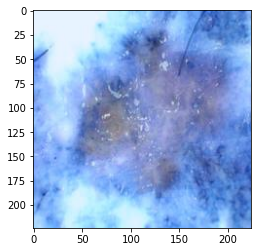

Image: 10


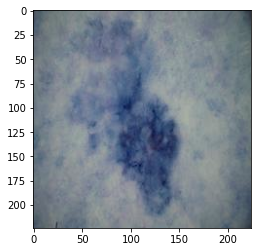

In [ ]:
for i in range(10):

  print("Image:",i+1)

  plt.imshow(images[i])

  plt.show()

### Data Augumentation: With Blurs and Distorsions

In [ ]:
transform = A.Compose([

                       A.Transpose(p=0.5),

                       A.VerticalFlip(p=0.5),

                       A.HorizontalFlip(p=0.5),

                       A.Rotate(p=0.5),

                       A.RandomBrightness(limit=0.2, p=0.5),

                       A.RandomContrast(limit=0.2, p=0.5),

                       A.OneOf([

                                A.MotionBlur(blur_limit=5, p=0.25),

                                A.MedianBlur(blur_limit=5, p=0.25),

                                A.GaussianBlur(blur_limit=5, p=0.25),

                                A.GaussNoise(var_limit=(5.0, 30.0), p=0.25)                                

                       ]),

                       A.OneOf([

                                A.OpticalDistortion(distort_limit=1.0, p=0.25),

                                A.GridDistortion(num_steps=5, distort_limit=1., p=0.25),

                                A.ElasticTransform(alpha=3, p=0.25)                               

                       ]),

                       A.CLAHE(clip_limit=4.0, p=0.7),

                       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),

                       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),

                       A.Resize(width=722, height=542, p=0.5),

                       A.Normalize(max_pixel_value=255.0,p=0.5),

                       A.Cutout(max_h_size=int(h[i]*0.1), max_w_size=int(w[i]*0.1), num_holes=8, p=0.7)

                       ])

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


### Data Augumentation: Without Blurs and Distorsions

In [ ]:
transform1 = A.Compose([

                        A.Transpose(p=0.5),

                        A.Flip(p=0.5),

                        A.OneOf([

                                 A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),

                                 A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)

                                 ],p=1),

                        A.GaussianBlur(p=0.05),

                        A.HueSaturationValue(p=0.5),

                        A.RGBShift(p=0.5),

                        ])

### Augmentation of first 50 images images with the 2 augmentations

Sample Image 1:


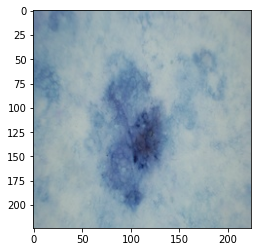

Augmentated Image with Blur and distorsion 1:


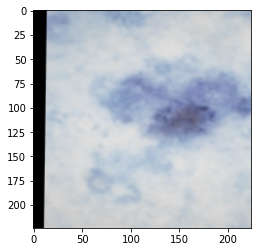

Augmentated Image without Blur and distorsion 1:


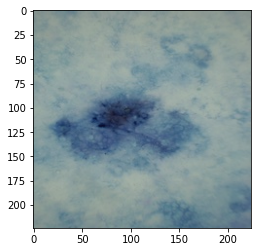

Sample Image 2:


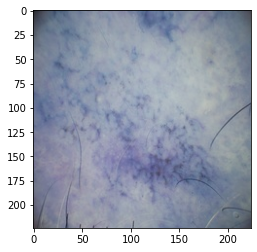

Augmentated Image with Blur and distorsion 2:


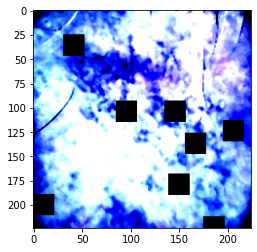

Augmentated Image without Blur and distorsion 2:


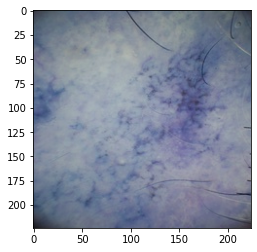

Sample Image 3:


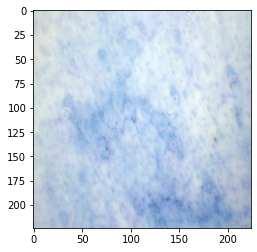

Augmentated Image with Blur and distorsion 3:


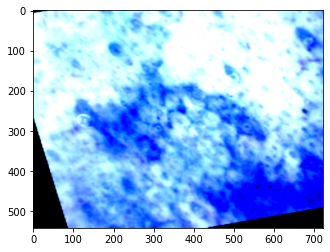

Augmentated Image without Blur and distorsion 3:


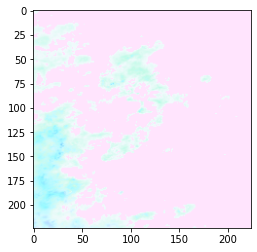

Sample Image 4:


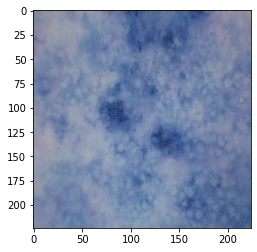

Augmentated Image with Blur and distorsion 4:


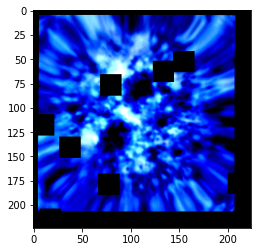

Augmentated Image without Blur and distorsion 4:


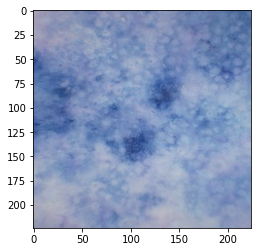

Sample Image 5:


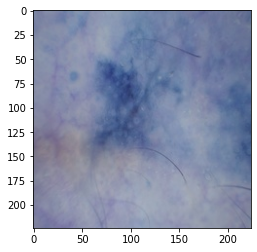

Augmentated Image with Blur and distorsion 5:


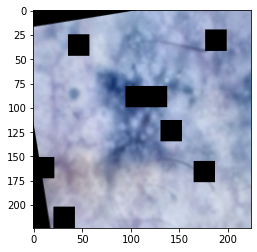

Augmentated Image without Blur and distorsion 5:


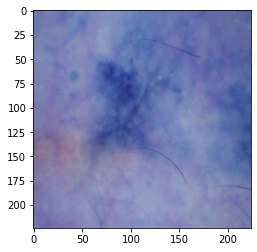

Sample Image 6:


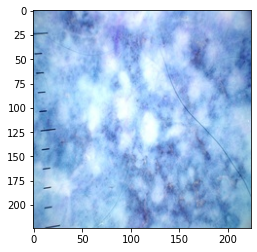

Augmentated Image with Blur and distorsion 6:


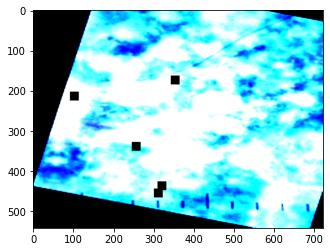

Augmentated Image without Blur and distorsion 6:


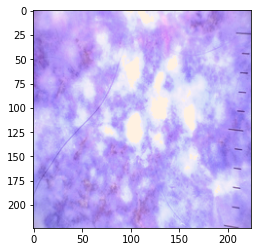

Sample Image 7:


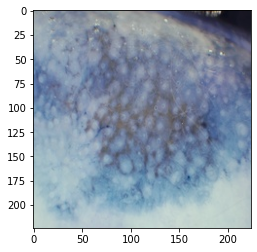

Augmentated Image with Blur and distorsion 7:


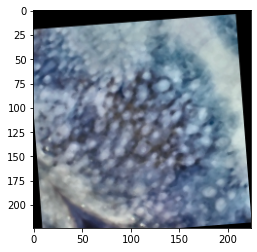

Augmentated Image without Blur and distorsion 7:


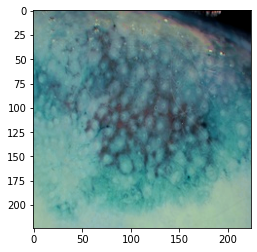

Sample Image 8:


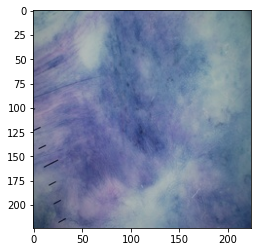

Augmentated Image with Blur and distorsion 8:


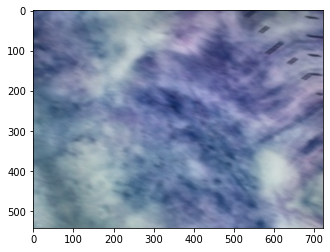

Augmentated Image without Blur and distorsion 8:


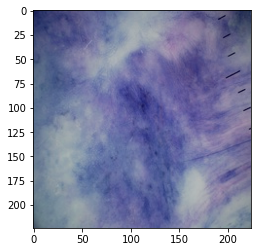

Sample Image 9:


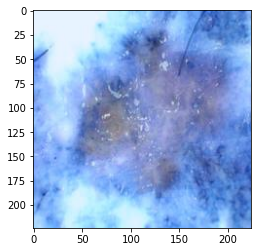

Augmentated Image with Blur and distorsion 9:


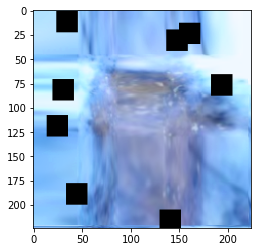

Augmentated Image without Blur and distorsion 9:


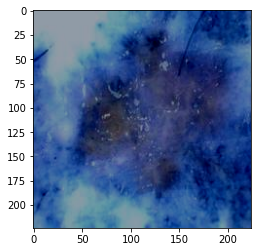

Sample Image 10:


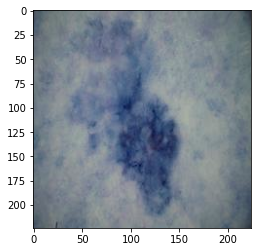

Augmentated Image with Blur and distorsion 10:


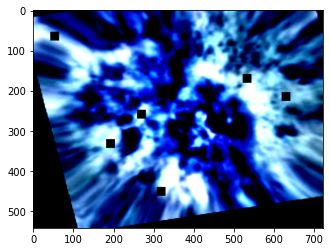

Augmentated Image without Blur and distorsion 10:


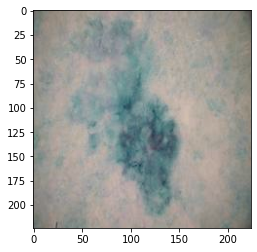

Sample Image 11:


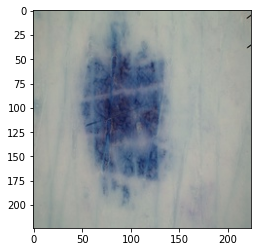

Augmentated Image with Blur and distorsion 11:


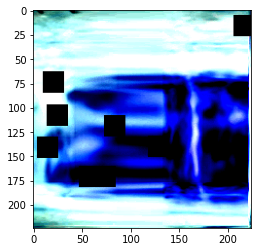

Augmentated Image without Blur and distorsion 11:


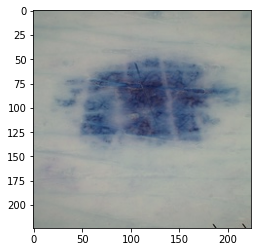

Sample Image 12:


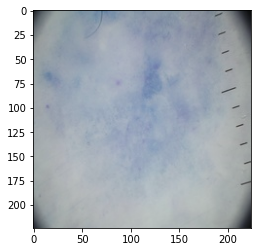

Augmentated Image with Blur and distorsion 12:


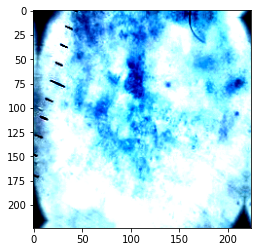

Augmentated Image without Blur and distorsion 12:


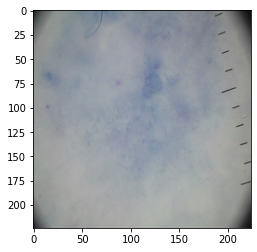

Sample Image 13:


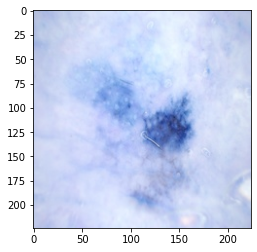

Augmentated Image with Blur and distorsion 13:


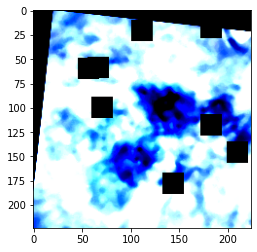

Augmentated Image without Blur and distorsion 13:


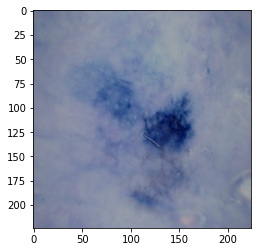

Sample Image 14:


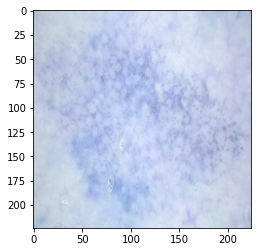

Augmentated Image with Blur and distorsion 14:


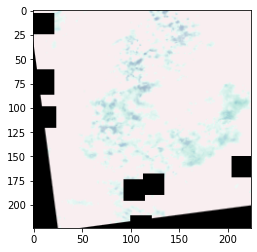

Augmentated Image without Blur and distorsion 14:


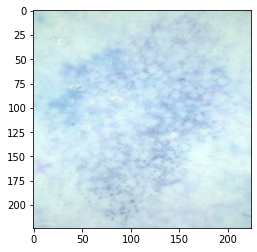

Sample Image 15:


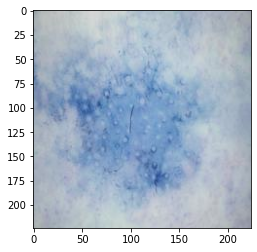

Augmentated Image with Blur and distorsion 15:


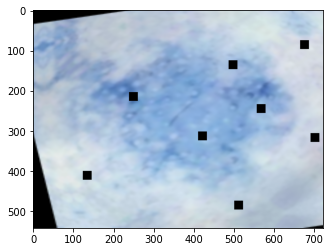

Augmentated Image without Blur and distorsion 15:


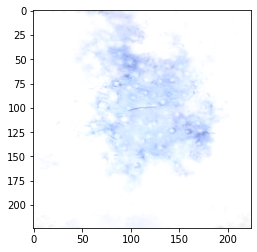

Sample Image 16:


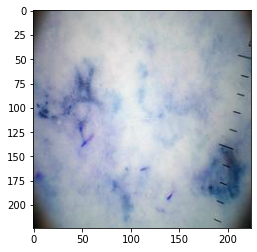

Augmentated Image with Blur and distorsion 16:


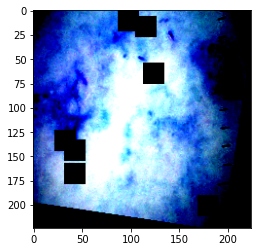

Augmentated Image without Blur and distorsion 16:


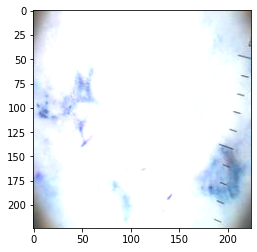

Sample Image 17:


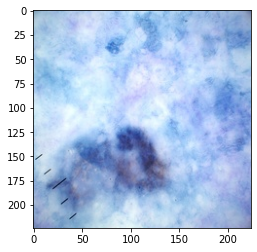

Augmentated Image with Blur and distorsion 17:


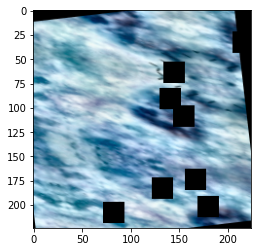

Augmentated Image without Blur and distorsion 17:


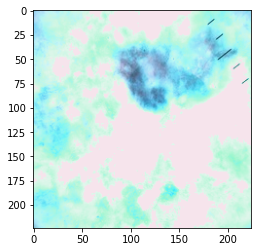

Sample Image 18:


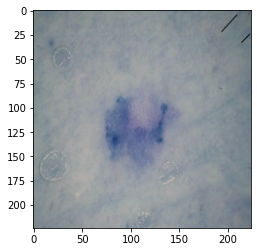

Augmentated Image with Blur and distorsion 18:


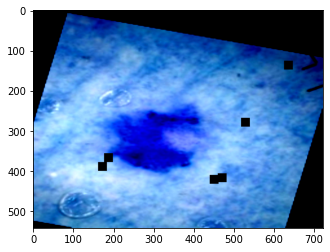

Augmentated Image without Blur and distorsion 18:


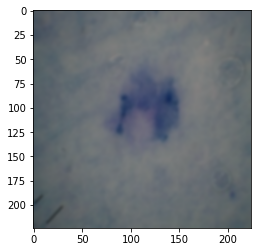

Sample Image 19:


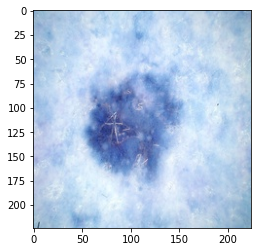

Augmentated Image with Blur and distorsion 19:


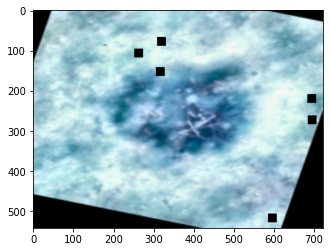

Augmentated Image without Blur and distorsion 19:


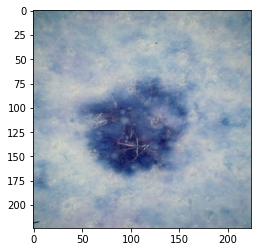

Sample Image 20:


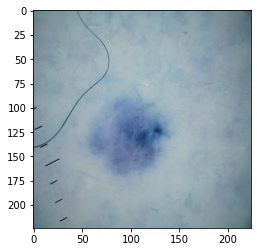

Augmentated Image with Blur and distorsion 20:


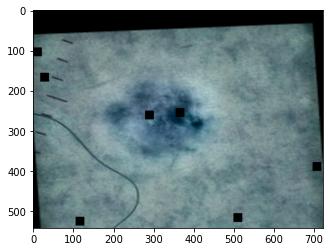

Augmentated Image without Blur and distorsion 20:


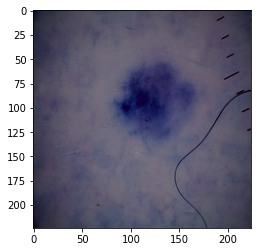

In [ ]:
for i in range(20):

  #with Blur and distorsion

  transformed = transform(image=images[i])

  transformed_image = transformed["image"]

  

  #without Blur and distorsion

  transformed1 = transform1(image=images[i])

  transformed_image1 = transformed1["image"]

  

  print('Sample Image {}:'.format(i+1))

  plt.imshow(images[i])

  plt.show()

  

  print('Augmentated Image with Blur and distorsion {}:'.format(i+1))

  plt.imshow(transformed_image)

  plt.show()



  print('Augmentated Image without Blur and distorsion {}:'.format(i+1))

  plt.imshow(transformed_image1)

  plt.show()